In [4]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
import glob
import gc

In [5]:
# set base path to the directory containing the csv files of the dataset
dataset_base_path_parquet = r'D:/GIU/Semester 7/Bachelor Thesis/Datasets/CICIDS 2018/full cicids 2018/processed/newPARQUET'

In [6]:
parquet_files = glob.glob(os.path.join(dataset_base_path_parquet, '*.parquet'))

network_data = pd.concat((pd.read_parquet(f) for f in parquet_files))

In [7]:
network_data.shape

(15738470, 80)

In [8]:
network_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15738470 entries, 0 to 601380
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   dst_port           uint32 
 1   protocol           uint8  
 2   timestamp          object 
 3   flow_duration      int64  
 4   tot_fwd_pkts       uint32 
 5   tot_bwd_pkts       uint32 
 6   totlen_fwd_pkts    uint32 
 7   totlen_bwd_pkts    uint32 
 8   fwd_pkt_len_max    uint16 
 9   fwd_pkt_len_min    uint16 
 10  fwd_pkt_len_mean   float32
 11  fwd_pkt_len_std    float32
 12  bwd_pkt_len_max    uint16 
 13  bwd_pkt_len_min    uint16 
 14  bwd_pkt_len_mean   float32
 15  bwd_pkt_len_std    float32
 16  flow_byts_s        float64
 17  flow_pkts_s        float64
 18  flow_iat_mean      float32
 19  flow_iat_std       float32
 20  flow_iat_max       int64  
 21  flow_iat_min       int64  
 22  fwd_iat_tot        int64  
 23  fwd_iat_mean       float32
 24  fwd_iat_std        float32
 25  fwd_iat_max       

In [9]:
def change_label(df):
    df.label.replace(['DoS attacks-GoldenEye', 'DoS attacks-Slowloris',
       'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk',],'DoS',inplace=True)
    df.label.replace(['DDoS attacks-LOIC-HTTP', 'DDOS attack-LOIC-UDP',
       'DDOS attack-HOIC'],'DDoS',inplace=True)
    df.label.replace(['FTP-BruteForce','SSH-Bruteforce'],'Bruteforce',inplace=True)
    df.label.replace(['Brute Force -Web', 'Brute Force -XSS',
       'SQL Injection'],'Web Attacks',inplace=True)

In [10]:
change_label(network_data)

In [11]:
# check the number of values for labels
network_data['label'].value_counts()

Benign           13385066
DDoS              1246366
DoS                506075
Bot                282310
Infilteration      161059
Bruteforce         156668
Web Attacks           926
Name: label, dtype: int64

In [12]:
label_encoder = LabelEncoder()
network_data['label']= label_encoder.fit_transform(network_data['label'])
network_data['label'].unique()

array([0, 5, 1, 2, 4, 3, 6])

In [13]:
# check for encoded labels
network_data['label'].value_counts()

0    13385066
3     1246366
4      506075
1      282310
5      161059
2      156668
6         926
Name: label, dtype: int64

In [14]:
network_data.shape

(15738470, 80)

In [15]:
network_data.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(network_data, test_size=0.2, random_state=132, stratify=network_data.label)

In [17]:
target_train = training_data['label']
target_test = testing_data['label']
target_train.unique(), target_test.unique()

(array([0, 4, 3, 1, 5, 2, 6]), array([0, 3, 1, 2, 4, 5, 6]))

In [18]:
training_data.drop(columns = ["timestamp","label"], axis=1, inplace = True)
testing_data.drop(columns = ["timestamp","label"], axis=1, inplace = True)

In [19]:
print(training_data.shape)
print(testing_data.shape)
print(target_train.shape)
print(target_test.shape)

(12590776, 78)
(3147694, 78)
(12590776,)
(3147694,)


In [20]:
y_train = to_categorical(target_train, num_classes=7)
y_test = to_categorical(target_test, num_classes=7)

In [18]:
# %%time
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import SelectFromModel

# sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
# sel.fit(X_train, y_train)

In [19]:
# selected_feat = X_train.columns[(sel.get_support())]
# print(selected_feat)

In [20]:
# len(selected_feat)

In [21]:
selected_feat = ['bwd_header_len', 'bwd_pkt_len_mean','bwd_pkt_len_std', 
       'dst_port', 'flow_duration', 'flow_iat_max','flow_iat_mean', 
       'flow_iat_min', 'flow_pkts_s', 'fwd_header_len',
       'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_tot',
       'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'fwd_pkts_s',
       'fwd_seg_size_avg', 'fwd_seg_size_min', 'init_fwd_win_byts',
       'pkt_size_avg', 'subflow_fwd_byts', 'totlen_fwd_pkts', 'tot_bwd_pkts']

In [22]:
X_train = training_data[selected_feat]
X_train.shape

(12590776, 25)

In [23]:
X_test = testing_data[selected_feat]
X_test.shape

(3147694, 25)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12590776, 25)
(3147694, 25)
(12590776, 7)
(3147694, 7)


In [25]:
del network_data
gc.collect()

57

In [26]:
del training_data,testing_data,target_train,target_test

In [27]:
gc.collect()

0

# XGBoost (XGB-7C)

In [28]:
%%time
# Import the necessary libraries
from xgboost import XGBClassifier

Wall time: 128 ms


In [60]:
%%time
# Import the necessary libraries
from xgboost import XGBClassifier


# model3 = XGBClassifier(n_estimators = 2000,
#                         max_depth = 10,
#                         reg_lambda = 4.8139,
#                         min_samples_split = 254,
#                         random_state = 5, tree_method = 'hist',n_jobs = -1)

# model3.fit(X_train, y_train)

[20:05:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

Wall time: 3h 3min 29s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              min_samples_split=254, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', ...)

In [67]:
# import pickle

# with open('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/XGB_V5.3.7.pkl','wb') as file:
#     pickle.dump(model3,file)

In [29]:
import pickle

with open('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/XGB_V5.3.7.pkl','rb') as f:
    model3 = pickle.load(f)

In [30]:
%%time
Y_test_pred3 = model3.predict(X_test)

Wall time: 2min 15s


In [31]:
test_accuracy = model3.score(X_test,y_test)
print("Test score is:",test_accuracy)

Test score is: 0.989499296945637


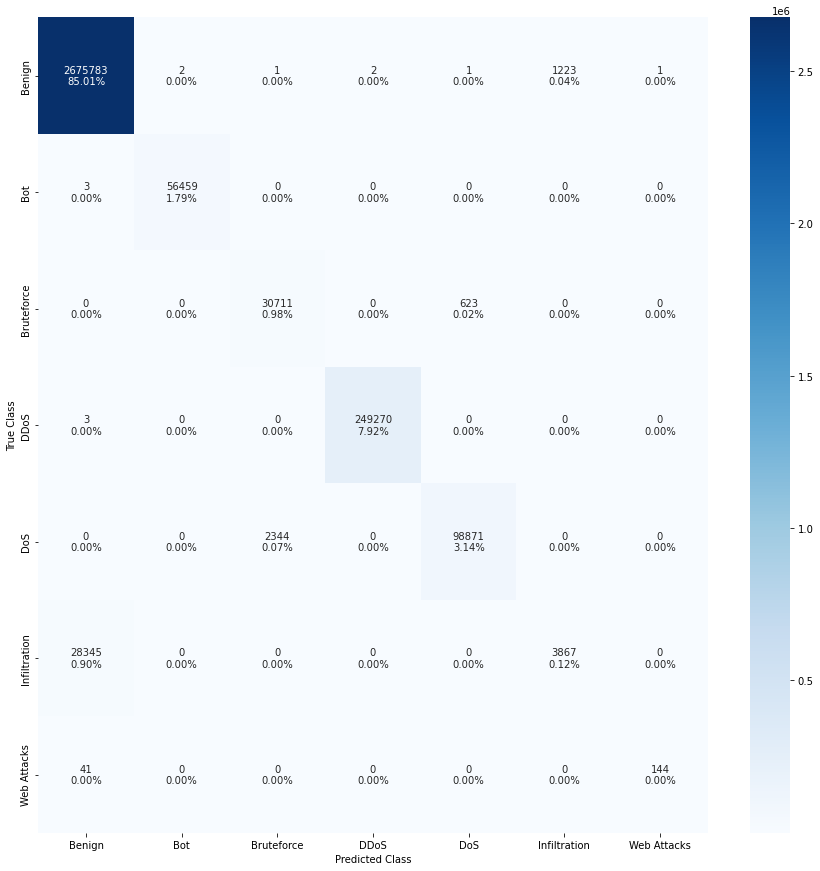

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 

y_pred = Y_test_pred3

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(7,7)

label = ['Benign','Bot','Bruteforce','DDoS','DoS','Infiltration','Web Attacks']

plt.figure(figsize=(15,15))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [33]:
from sklearn.metrics import classification_report



print(classification_report(y_test_cm, y_pred_cm, target_names= label,digits=5))
                            
# accuracy = model3.score(X_test,y_test)
accuracy = test_accuracy
print("Test: accuracy = %f  " % (accuracy))

              precision    recall  f1-score   support

      Benign    0.98950   0.99954   0.99450   2677013
         Bot    0.99996   0.99995   0.99996     56462
  Bruteforce    0.92906   0.98012   0.95391     31334
        DDoS    0.99999   0.99999   0.99999    249273
         DoS    0.99373   0.97684   0.98521    101215
Infiltration    0.75972   0.12005   0.20733     32212
 Web Attacks    0.99310   0.77838   0.87273       185

    accuracy                        0.98965   3147694
   macro avg    0.95215   0.83641   0.85909   3147694
weighted avg    0.98770   0.98965   0.98626   3147694

Test: accuracy = 0.989499  


# Random Forest (RF-7C)

In [57]:
# %%time
# #RANDOM FOREST
# model3 = RandomForestClassifier(n_estimators=200,n_jobs=-1)
# model3.fit(X_train, y_train)

Wall time: 3h 16min 19s


RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [ ]:
# import pickle

# with open('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/RF_V5.3.7.pkl','wb') as f:
#     pickle.dump(model3,f)

In [ ]:
import pickle

with open('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/RF_V5.3.7.pkl','rb') as f:
    model3 = pickle.load(f)

In [27]:
%%time
Y_test_pred3 = model3.predict(X_test)

Wall time: 4min 4s


In [28]:
test_accuracy = model3.score(X_test,y_test)
print("Test score is:",test_accuracy)

Test score is: 0.992406504571283


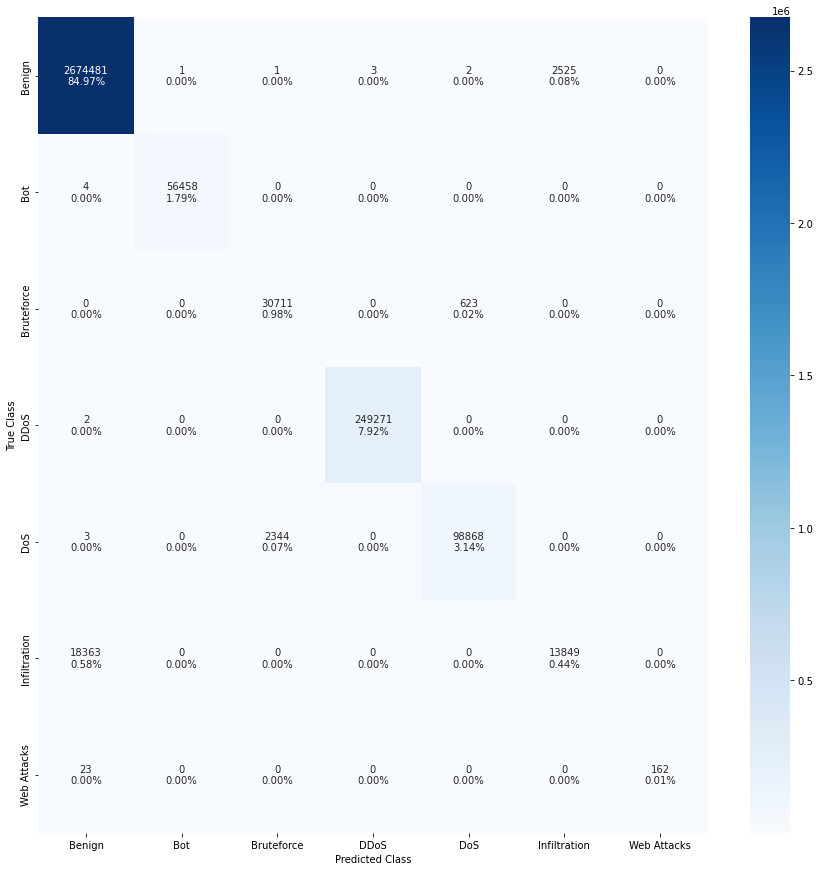

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 
#model = tf.keras.models.load_model('/'+model_name+'.h5')

y_pred = model3.predict(X_test)

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm)

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(7,7)


label = ['Benign','Bot','Bruteforce','DDoS','DoS','Infiltration','Web Attacks']


plt.figure(figsize=(15,15))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
# plt.title('Confusion Matrix for'+ modelName+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
# plt.savefig('./'+modelName+'_CM.png')
plt.show()

In [30]:
from sklearn.metrics import classification_report



print(classification_report(y_test_cm, y_pred_cm, target_names= label,digits=5))
                            
# accuracy = model3.score(X_test,y_test)
accuracy = model3.score(X_test,y_test)#test_accuracy
print("Test: accuracy = %f  " % (accuracy))

              precision    recall  f1-score   support

      Benign    0.99317   0.99905   0.99610   2677013
         Bot    0.99998   0.99993   0.99996     56462
  Bruteforce    0.92906   0.98012   0.95391     31334
        DDoS    0.99999   0.99999   0.99999    249273
         DoS    0.99372   0.97681   0.98519    101215
Infiltration    0.84579   0.42993   0.57008     32212
 Web Attacks    1.00000   0.87568   0.93372       185

    accuracy                        0.99241   3147694
   macro avg    0.96596   0.89450   0.91985   3147694
weighted avg    0.99170   0.99241   0.99135   3147694

Test: accuracy = 0.992407  


# CNN (CNN-7C)

In [32]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

scalar1 = scaler.fit_transform(X_train)
scalar2 = scaler.fit_transform(X_test)

X_train = pd.DataFrame(scalar1)
X_test = pd.DataFrame(scalar2)

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.039661,-0.306430,-0.658887,-0.484387,-0.026016,-0.010581,-0.013528,-0.003702,-0.142391,-0.020578,...,-0.228573,-0.621471,-0.130236,-0.228573,-1.330464,-0.525628,-0.196401,-0.018489,-0.018489,-0.033702
1,0.004802,4.112337,2.284828,-0.463821,-0.025560,-0.010497,-0.013467,-0.003703,-0.151184,-0.009065,...,3.019699,3.224292,-0.134966,3.019699,0.348419,-0.021710,3.896463,0.012520,0.012520,0.003258
2,-0.037190,-0.373015,-0.658887,-0.484387,-0.025807,-0.010487,-0.013401,-0.003703,-0.151299,-0.019938,...,-0.212109,-0.621471,-0.135028,-0.212109,-1.330464,-0.525628,-0.327570,-0.017718,-0.017718,-0.027542
3,-0.035955,-0.705935,-0.658887,2.306645,-0.026019,-0.010583,-0.013532,-0.003703,0.113029,-0.019618,...,-0.854236,-0.621471,0.007175,-0.854236,0.348419,-0.500903,-0.849945,-0.019222,-0.019222,-0.033702
4,0.003567,0.661202,1.429096,-0.308471,-0.022341,-0.009077,-0.013045,-0.003703,-0.151445,-0.007786,...,1.508464,1.318567,-0.135105,1.508464,0.348419,-0.021710,0.824722,0.002903,0.002903,0.003258


In [33]:
# reshape the data for CNN
X_train = X_train.values
X_test = X_test.values


X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((12590776, 25, 1), (3147694, 25, 1))

In [ ]:
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [ ]:
from keras.layers import Dense, Dropout, Activation, Lambda

# making the deep learning function
def model():
    model = Sequential()
    model.add(Conv1D(32,3,activation='relu',padding='same',kernel_initializer='he_uniform',input_shape=(X_train.shape[1], 1)))
    model.add(Conv1D(32,3,activation='relu',padding='same',kernel_initializer='he_uniform'))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform'))
    model.add(Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform')) 
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())    

    model.add(Flatten())
    model.add(Dense(32,activation='relu'))
    model.add(Dense(7,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [40]:
model = model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 25, 32)            128       
                                                                 
 conv1d_5 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 12, 32)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 32)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 12, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_6 (Conv1D)           (None, 12, 64)           

In [42]:
batch_size = 256
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train, y_train, epochs=25#
                , batch_size=batch_size, 
          validation_data=(X_test, y_test), callbacks=[logger])

Epoch 1/25
49183/49183 [==============================] - 725s 15ms/step - loss: 0.0579 - accuracy: 0.9865 - val_loss: 0.0725 - val_accuracy: 0.9813
Epoch 2/25
49183/49183 [==============================] - 733s 15ms/step - loss: 0.0534 - accuracy: 0.9875 - val_loss: 0.0726 - val_accuracy: 0.9738
Epoch 3/25
49183/49183 [==============================] - 735s 15ms/step - loss: 0.0525 - accuracy: 0.9877 - val_loss: 0.0616 - val_accuracy: 0.9840
Epoch 4/25
49183/49183 [==============================] - 736s 15ms/step - loss: 0.0521 - accuracy: 0.9879 - val_loss: 0.0840 - val_accuracy: 0.9817
Epoch 5/25
49183/49183 [==============================] - 751s 15ms/step - loss: 0.0518 - accuracy: 0.9879 - val_loss: 0.0700 - val_accuracy: 0.9824
Epoch 6/25
49183/49183 [==============================] - 755s 15ms/step - loss: 0.0516 - accuracy: 0.9880 - val_loss: 0.0710 - val_accuracy: 0.9754
Epoch 7/25
49183/49183 [==============================] - 762s 15ms/step - loss: 0.0514 - accuracy: 0.9880

In [ ]:
model.save("D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/CNN_V5.3.7.h5")

In [ ]:
from keras.models import load_model


loaded_model = load_model('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/CNN_V5.3.7.h5')

98366/98366 [==============================] - 173s 2ms/step


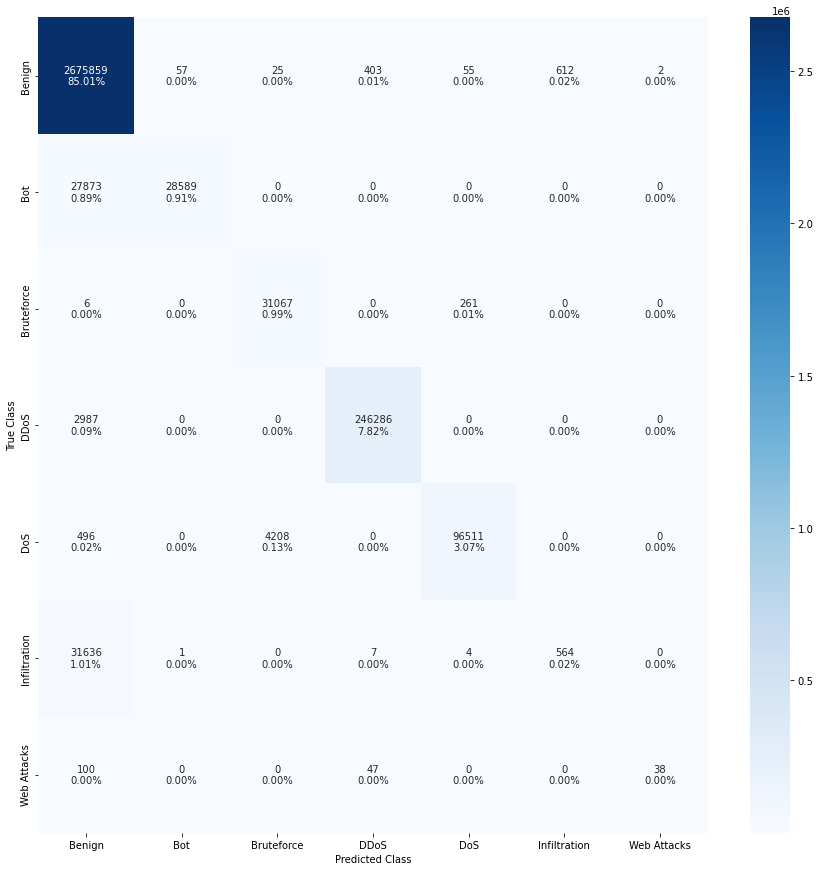

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 
#model = tf.keras.models.load_model('/'+model_name+'.h5')

y_pred = model.predict(X_test)

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(7,7)

label = ['Benign','Bot','Bruteforce','DDoS','DoS','Infiltration','Web Attacks']

plt.figure(figsize=(15,15))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
# plt.title('Confusion Matrix for'+ modelName+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
# plt.savefig('./'+modelName+'_CM.png')
plt.show()

In [45]:
from sklearn.metrics import classification_report



print(classification_report(y_test_cm, y_pred_cm, target_names= label,digits=5))
                            
loss, accuracy = model.evaluate(X_test,y_test, verbose = 1)
print("Test: accuracy = %f ; loss = %f " % (accuracy,loss))

              precision    recall  f1-score   support

      Benign    0.97696   0.99957   0.98814   2677013
         Bot    0.99798   0.50634   0.67182     56462
  Bruteforce    0.88008   0.99148   0.93247     31334
        DDoS    0.99815   0.98802   0.99306    249273
         DoS    0.99670   0.95352   0.97463    101215
Infiltration    0.47959   0.01751   0.03378     32212
 Web Attacks    0.95000   0.20541   0.33778       185

    accuracy                        0.97815   3147694
   macro avg    0.89707   0.66598   0.70453   3147694
weighted avg    0.97360   0.97815   0.97206   3147694

98366/98366 [==============================] - 195s 2ms/step - loss: 0.1745 - accuracy: 0.9781
Test: accuracy = 0.978149 ; loss = 0.174516 


# DNN (DNN-7C)

In [102]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

scalar1 = scaler.fit_transform(X_train)
scalar2 = scaler.fit_transform(X_test)

X_train = pd.DataFrame(scalar1)
X_test = pd.DataFrame(scalar2)

X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.039661,-0.306430,-0.658887,-0.484387,-0.026016,-0.010581,-0.013528,-0.003702,-0.142391,-0.020578,...,-0.228573,-0.621471,-0.130236,-0.228573,-1.330464,-0.525628,-0.196401,-0.018489,-0.018489,-0.033702
1,0.004802,4.112337,2.284828,-0.463821,-0.025560,-0.010497,-0.013467,-0.003703,-0.151184,-0.009065,...,3.019699,3.224292,-0.134966,3.019699,0.348419,-0.021710,3.896463,0.012520,0.012520,0.003258
2,-0.037190,-0.373015,-0.658887,-0.484387,-0.025807,-0.010487,-0.013401,-0.003703,-0.151299,-0.019938,...,-0.212109,-0.621471,-0.135028,-0.212109,-1.330464,-0.525628,-0.327570,-0.017718,-0.017718,-0.027542
3,-0.035955,-0.705935,-0.658887,2.306645,-0.026019,-0.010583,-0.013532,-0.003703,0.113029,-0.019618,...,-0.854236,-0.621471,0.007175,-0.854236,0.348419,-0.500903,-0.849945,-0.019222,-0.019222,-0.033702
4,0.003567,0.661202,1.429096,-0.308471,-0.022341,-0.009077,-0.013045,-0.003703,-0.151445,-0.007786,...,1.508464,1.318567,-0.135105,1.508464,0.348419,-0.021710,0.824722,0.002903,0.002903,0.003258


In [ ]:
import tensorflow as tf

def model():

    # Define the model
    model = tf.keras.Sequential()

    # Add the layers
    model.add(tf.keras.layers.Dense(300, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    #newly added
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.Dense(7, activation='softmax'))

    # Compile the model
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.00061)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model



In [ ]:
model = model()
model.summary()

In [37]:
%%time
# Fit the model to the training data
logger = CSVLogger('logs.csv', append=True)

his = model.fit(X_train, y_train, batch_size=4096, epochs=25, validation_data=(X_test, y_test),callbacks=[logger])

Epoch 1/25
3074/3074 [==============================] - 399s 129ms/step - loss: 0.0595 - accuracy: 0.9867 - val_loss: 0.3867 - val_accuracy: 0.9497
Epoch 2/25
3074/3074 [==============================] - 407s 132ms/step - loss: 0.0557 - accuracy: 0.9872 - val_loss: 0.4197 - val_accuracy: 0.9419
Epoch 3/25
3074/3074 [==============================] - 403s 131ms/step - loss: 0.0546 - accuracy: 0.9874 - val_loss: 0.5974 - val_accuracy: 0.9085
Epoch 4/25
3074/3074 [==============================] - 403s 131ms/step - loss: 0.0541 - accuracy: 0.9874 - val_loss: 0.5301 - val_accuracy: 0.9296
Epoch 5/25
3074/3074 [==============================] - 404s 131ms/step - loss: 0.0537 - accuracy: 0.9875 - val_loss: 0.8478 - val_accuracy: 0.9141
Epoch 6/25
3074/3074 [==============================] - 405s 132ms/step - loss: 0.0534 - accuracy: 0.9876 - val_loss: 0.4905 - val_accuracy: 0.9136
Epoch 7/25
3074/3074 [==============================] - 403s 131ms/step - loss: 0.0531 - accuracy: 0.9877 - val_

In [38]:
model.save("D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/DNN_V5.3.7.h5")

In [ ]:
from keras.models import load_model


loaded_model = load_model('D:/GIU/Semester 7/Bachelor Thesis/Project Code/models/DNN_V5.3.7.h5')

98366/98366 [==============================] - 195s 2ms/step


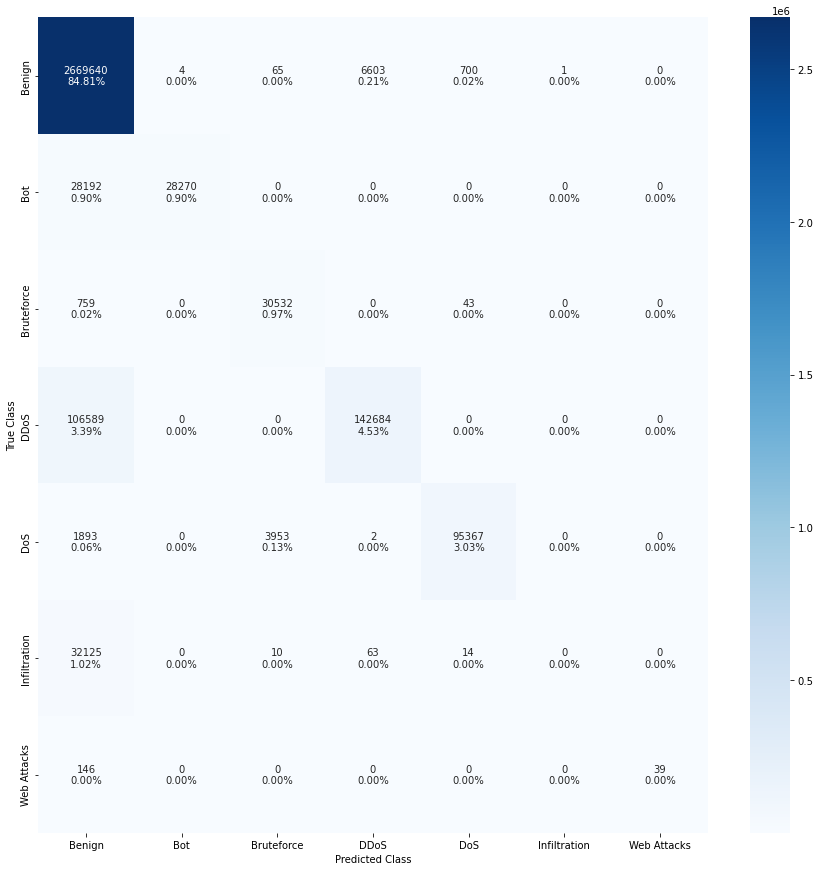

In [103]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support,  roc_curve, auc
import tensorflow as tf 
#model = tf.keras.models.load_model('/'+model_name+'.h5')

y_pred = model.predict(X_test)

y_pred_cm  = np.argmax(y_pred, axis=1)
y_test_cm  = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_cm, y_pred_cm) 

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(7,7)

label = ['Benign','Bot','Bruteforce','DDoS','DoS','Infiltration','Web Attacks']

plt.figure(figsize=(15,15))
sns.heatmap(cm, xticklabels=label, yticklabels=label, annot=labels, fmt='', cmap="Blues", vmin = 0.2);
# plt.title('Confusion Matrix for'+ modelName+' model')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
# plt.savefig('./'+modelName+'_CM.png')
plt.show()

In [104]:
from sklearn.metrics import classification_report



print(classification_report(y_test_cm, y_pred_cm, target_names= label,digits=5))
                            
loss, accuracy = model.evaluate(X_test,y_test, verbose = 1)
print("Test: accuracy = %f ; loss = %f " % (accuracy,loss))

              precision    recall  f1-score   support

      Benign    0.94023   0.99725   0.96790   2677013
         Bot    0.99986   0.50069   0.66725     56462
  Bruteforce    0.88345   0.97440   0.92670     31334
        DDoS    0.95535   0.57240   0.71588    249273
         DoS    0.99212   0.94222   0.96653    101215
Infiltration    0.00000   0.00000   0.00000     32212
 Web Attacks    1.00000   0.21081   0.34821       185

    accuracy                        0.94245   3147694
   macro avg    0.82443   0.59968   0.65607   3147694
weighted avg    0.93398   0.94245   0.93215   3147694

98366/98366 [==============================] - 217s 2ms/step - loss: 0.7162 - accuracy: 0.9424
Test: accuracy = 0.942446 ; loss = 0.716153 
